<a href="https://colab.research.google.com/github/BrunoKedzierski/Titianic_DataScience/blob/main/Titanic_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Step 1: initial exploration and data cleaning


---


Load data from csv and inspect first rows:


In [2]:
import pandas as pd
import numpy as np

titanic_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/titanic.csv')
titanic_data.head()


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


Calculate the percentage of missing values for each column:


---



In [3]:
titanic_data.isna().sum()/len(titanic_data.index)

pclass       0.000000
survived     0.000000
name         0.000000
sex          0.000000
age          0.200917
sibsp        0.000000
parch        0.000000
ticket       0.000000
fare         0.000764
cabin        0.774637
embarked     0.001528
boat         0.628724
body         0.907563
home_dest    0.430863
dtype: float64

Drop all columns which have more then 1/3 missing values, then show descriptive statistics for each column.


---



In [4]:
titanic_data = titanic_data.drop(columns=['boat', 'body','ticket', 'cabin','home_dest'])
titanic_data.describe()

,pclass,survived,age,sibsp,parch,fare
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200


# Step 2: feature engineering


---
Creating the "demographic" category feature, based on titles/honorifics. Then printing all titles

In [5]:
import re
titanic_data['demographic_class'] = titanic_data['name'].apply(lambda x: re.findall('[A-Z][a-z]*\\.',x)[0])
titanic_data['demographic_class'].unique()


array(['Miss.', 'Master.', 'Mr.', 'Mrs.', 'Col.', 'Mme.', 'Dr.', 'Major.',
       'Capt.', 'Lady.', 'Sir.', 'Mlle.', 'Dona.', 'Jonkheer.',
       'Countess.', 'Don.', 'Rev.', 'Ms.'], dtype=object)

Use the demographic class to impute missing age values - I assume that people having similar titles migh be of smiliar age. I compute mean age by class and impute missing age values


---



In [6]:
age_by_class = titanic_data[['demographic_class','age']].groupby('demographic_class').mean(['age'])
titanic_data['age'] = titanic_data.apply(lambda row: age_by_class.loc[row['demographic_class']]['age'] if np.isnan(row['age']) else row['age'], axis=1) 

Create age bins - binning age values into: infants, children, teenager and adults


---



In [7]:
def age_bins(age):
  if age <= 6:
    return "infant"
  elif age <=12:
    return "child"
  elif age <=18:
    return "teenager"
  return "adult"
titanic_data['age_range']  = titanic_data['age'].apply(age_bins)



calcualting two addinitional features - family sizes and mpc


---



In [8]:
titanic_data['family_size'] = titanic_data['parch'] + titanic_data['sibsp'] +1
titanic_data['mpc'] = titanic_data['age'] * titanic_data['pclass']

again inspecting missing values - we still have NA's in fare and embarked 
features


---



In [9]:
titanic_data.isna().sum()

pclass               0
survived             0
name                 0
sex                  0
age                  0
sibsp                0
parch                0
fare                 1
embarked             2
demographic_class    0
age_range            0
family_size          0
mpc                  0
dtype: int64

to impute fare values I use a mean for each pclass - I assume that ticket prices are mostly dependent on the class


---



In [10]:
fare_by_class = titanic_data[['fare','pclass']].groupby('pclass').mean(['fare'])
titanic_data['fare'] = titanic_data.apply(lambda row: fare_by_class.loc[row['pclass']]['fare'] if np.isnan(row['fare']) else row['fare'], axis=1) 

for the embarked column, which is just the name of the embarked port - I impute the values by using the most frequent port.


---



In [11]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
titanic_data['embarked'] = imp.fit_transform(titanic_data['embarked'].values.reshape(-1, 1))

Finally the data has no missing values


---



In [12]:
titanic_data.isna().sum()

pclass               0
survived             0
name                 0
sex                  0
age                  0
sibsp                0
parch                0
fare                 0
embarked             0
demographic_class    0
age_range            0
family_size          0
mpc                  0
dtype: int64

In [13]:
titanic_data.describe()

,pclass,survived,age,sibsp,parch,fare,family_size,mpc
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,2.294882,0.381971,29.896891,0.498854,0.385027,33.280206,1.883881,64.437736
std,0.837836,0.486055,13.193809,1.041658,0.865560,51.741830,1.583639,32.369252
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000,0.500100
25%,2.000000,0.000000,21.774207,0.000000,0.000000,7.895800,1.000000,42.000000
50%,3.000000,0.000000,30.000000,0.000000,0.000000,14.454200,1.000000,63.000000
75%,3.000000,1.000000,36.000000,1.000000,0.000000,31.275000,2.000000,90.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,11.000000,222.000000


# Step 3: Exploratory data analysis


---
check correlation matrix between the numerical variables

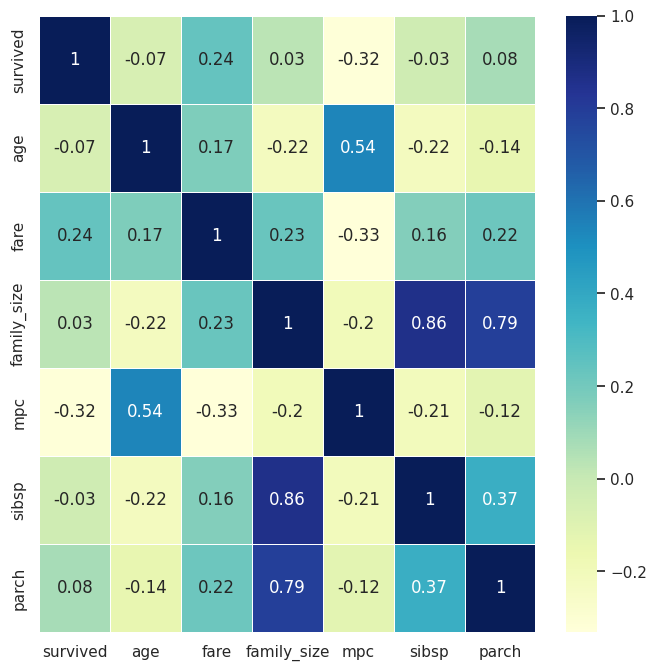

In [14]:
correlation_matrix = round(titanic_data[['survived','age','fare','family_size','mpc','sibsp','parch']].corr(),2)

import seaborn as sns
sns.set(rc={'figure.figsize':(8,8)})
g = sns.heatmap(correlation_matrix, cmap="YlGnBu", annot=True, linewidth=.5)


Show correlation table, highlit rows with high correlation coeffcients


---



In [15]:

def format_correlation(x):
  if(x == 1):
    return ''
  elif(x <= -0.7):
    return 'background-color: red'
  elif(x <= -0.5):
    return 'background-color: #ffcccb'   
  elif(x >= 0.7):
    return 'background-color: green'
  elif(x >= 0.5):
    return 'background-color: green'
  elif((abs(x) < 0.5) & (abs(x) > 0.2)):
      return 'background-color: #ffff00'    
  return ''
display(correlation_matrix.style.applymap(format_correlation))
display(g)

,survived,age,fare,family_size,mpc,sibsp,parch
survived,1.000000,-0.070000,0.240000,0.030000,-0.320000,-0.030000,0.080000
age,-0.070000,1.000000,0.170000,-0.220000,0.540000,-0.220000,-0.140000
fare,0.240000,0.170000,1.000000,0.230000,-0.330000,0.160000,0.220000
family_size,0.030000,-0.220000,0.230000,1.000000,-0.200000,0.860000,0.790000
mpc,-0.320000,0.540000,-0.330000,-0.200000,1.000000,-0.210000,-0.120000
sibsp,-0.030000,-0.220000,0.160000,0.860000,-0.210000,1.000000,0.370000
parch,0.080000,-0.140000,0.220000,0.790000,-0.120000,0.370000,1.000000


<Axes: >

next inspect the categorical variables


---



<Axes: xlabel='age_range', ylabel='survived'>

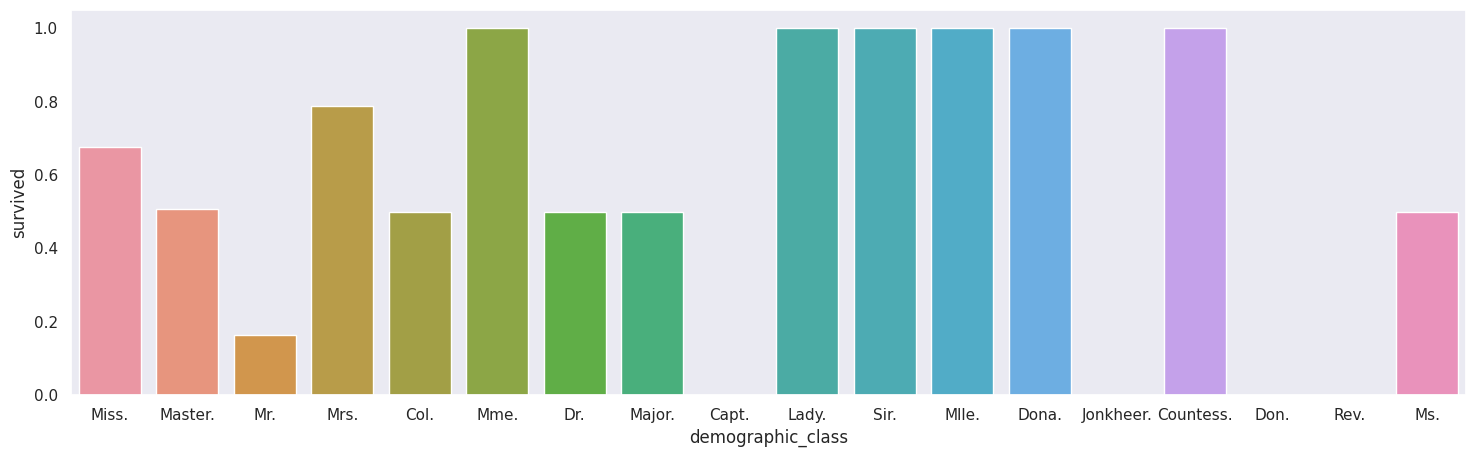

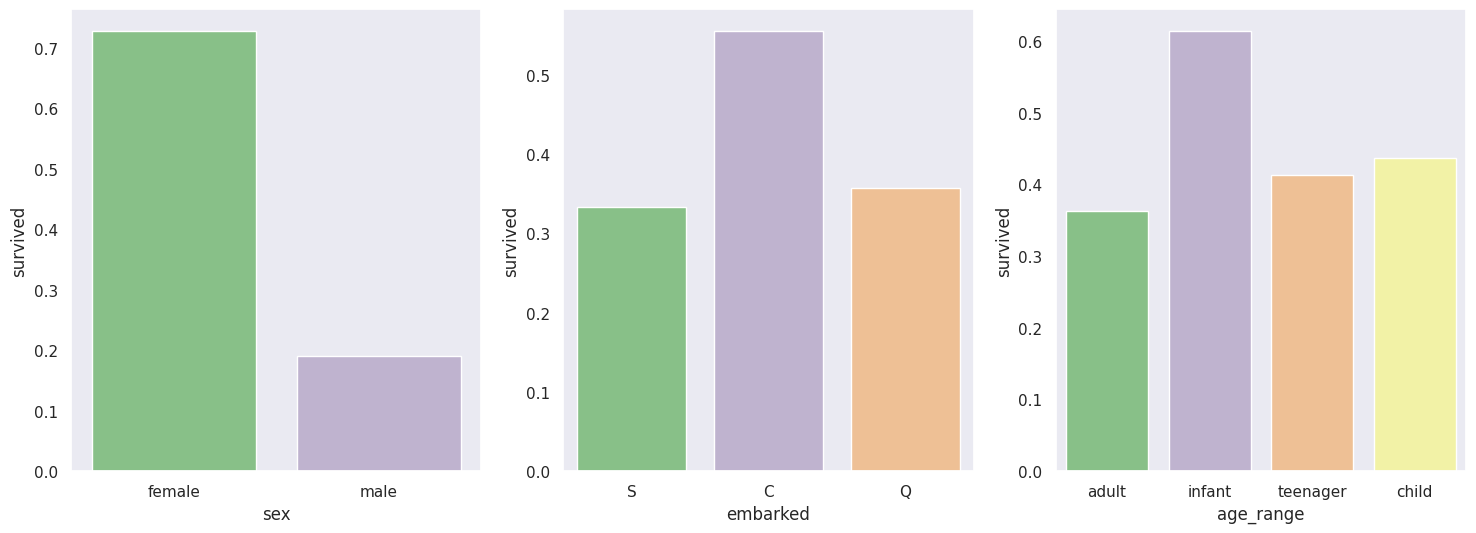

In [16]:
import matplotlib.pyplot as plt
sns.set_theme(style="dark", palette="Accent")
plt.figure(figsize=(18,5))
sns.barplot(data=titanic_data, x="demographic_class", y="survived", errorbar=None)


f,ax = plt.subplots(1,3,figsize=(18,6))
sns.barplot(data=titanic_data, x="sex", y="survived",ax=ax[0], errorbar=None)
sns.barplot(data=titanic_data, x="embarked", y="survived",ax=ax[1], errorbar=None)
sns.barplot(data=titanic_data, x="age_range", y="survived", ax=ax[2], errorbar=None)

# Step 4: prepare data for machine learning models


---
encode all categorical variables into numerical

In [17]:
sex_code = {'female': 0, 'male': 1}
embarked_code = {'S':0, 'C':1,'Q':2}
age_range_code = {'infant':0,'child':1,'teenager':2,'adult':3}
class_range = dict()
for idx, x in enumerate(titanic_data['demographic_class'].unique()):
  class_range[x] = idx

titanic_data['sex'] = titanic_data['sex'].map(sex_code)
titanic_data['embarked'] = titanic_data['embarked'].map(embarked_code)
titanic_data['age_range'] = titanic_data['age_range'].map(age_range_code)
titanic_data['demographic_class'] = titanic_data['demographic_class'].map(class_range)


Scaling all numerical variables using MinMax scaler


---



In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

scaler = MinMaxScaler()
titanic_data[['pclass','sex','embarked','age_range','demographic_class','age','fare','mpc','family_size','parch','sibsp']] = scaler.fit_transform(titanic_data[['pclass','sex','embarked','age_range','demographic_class','age','fare','mpc','family_size','parch','sibsp']])
titanic_data.describe()

,pclass,survived,sex,age,sibsp,parch,fare,embarked,demographic_class,age_range,family_size,mpc
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,0.647441,0.381971,0.644003,0.372403,0.062357,0.042781,0.064959,0.197097,0.112974,0.905017,0.088388,0.288658
std,0.418918,0.486055,0.478997,0.165267,0.130207,0.096173,0.100993,0.326750,0.107344,0.252529,0.158364,0.146137
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.000000,0.000000,0.270658,0.000000,0.000000,0.015412,0.000000,0.117647,1.000000,0.000000,0.187359
50%,1.000000,0.000000,1.000000,0.373695,0.000000,0.000000,0.028213,0.000000,0.117647,1.000000,0.000000,0.282167
75%,1.000000,1.000000,1.000000,0.448852,0.125000,0.000000,0.061045,0.500000,0.117647,1.000000,0.100000,0.404063
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Splitting data to targets and predictors


---



In [19]:
target = ['not_survived', 'survivied']
X = titanic_data[['pclass','sex','embarked','age_range','demographic_class','age','fare','mpc','family_size','parch','sibsp']]
y = titanic_data[['survived']]


Splitting data to train and test sets


---



In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)




# Step 4: Feature selecting, Hyperparameters tuning






Preparing feature sets for feature selection


---



In [21]:
f_set1 = ('pclass', 'sex', 'embarked','age','fare', 'parch','sibsp')
f_set2 = ('pclass', 'sex', 'embarked','age','fare', 'parch','sibsp', 'demographic_class')
f_set3 = ('mpc', 'sex', 'embarked','fare', 'family_size', 'demographic_class')
f_set4 = ('pclass', 'sex', 'embarked','age_range','fare', 'family_size','demographic_class')

f_sets = (f_set1,f_set2,f_set3,f_set4)

Defining grids for hyperparameter tuning


---



In [23]:
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
tree_grid = {
    'criterion' : ['gini'],
    'max_depth' : [4,5,6,7],
    'random_state': [1]
}

random_forest_grid= {
    'n_estimators': [200,250,300,350,400,500],
    'max_depth' : [4,5,6,7],
    'criterion' :['entropy'],
    'max_features': ['log2', 'sqrt'],
    'random_state' : [1]
    }


xgboost_grid = {
    'tree_method' :['gpu_hist'],
    'max_depth': [2,3,4,5,6,7],
    'n_estimators': [200,250,300,350,400,500],
    'learning_rate': [0.1, 0.01, 0.05],
    'objective' : ['binary:logistic'],
    'nthread':[4],
    'seed':[42],
    'predictor':['gpu_predictor']
}



Running grid search over parameter space


---



In [ ]:
clf_tree = tree.DecisionTreeClassifier()
clf_forest = RandomForestClassifier()
clf_xgboost = XGBClassifier()
res = dict()
for s in f_sets:

  tree_cv = GridSearchCV(clf_tree, param_grid=tree_grid, cv= 5, scoring = 'accuracy')
  tree_cv.fit(X_train[list(s)], y_train.values.ravel())

  random_forest_cv = GridSearchCV(clf_forest, param_grid=random_forest_grid, cv= 5, scoring = 'accuracy')
  random_forest_cv.fit(X_train[list(s)], y_train.values.ravel())


  xgboost_cv = GridSearchCV(clf_xgboost, param_grid=xgboost_grid, cv= 5, scoring = 'accuracy')
  xgboost_cv.fit(X_train[list(s)], y_train.values.ravel())


  display(tree_cv.best_params_)
  display(random_forest_cv.best_params_)
  display(xgboost_cv.best_params_)
  l = [tree_cv.best_params_,random_forest_cv.best_params_,xgboost_cv.best_params_]
  res[s] = l


print(res)


# Step 5: Model evaluation

Testing best features set/hyperparameter combinations on test set


---



In [30]:


for f,hp in res.items():
  print(f"features{f}")
  print(f"Hyperparameters{hp}")
  clf_tree = tree.DecisionTreeClassifier(**hp[0])
  clf_tree.fit(X_train[list(f)], y_train.values.ravel())
  print("Tree score: ")
  display(clf_tree.score(X_test[list(f)],y_test.values.ravel()))

  print("Forest score: ")
  clf_forest = RandomForestClassifier(**hp[1])
  clf_forest.fit(X_train[list(f)], y_train.values.ravel())
  display(clf_forest.score(X_test[list(f)],y_test.values.ravel()))


  print("XGBoost score: ")
  clf_xgboost = XGBClassifier(**hp[2])
  clf_xgboost.fit(X_train[list(f)], y_train.values.ravel())
  display(clf_xgboost.score(X_test[list(f)],y_test.values.ravel()))





('pclass', 'sex', 'embarked', 'age', 'fare', 'parch', 'sibsp')
[{'criterion': 'gini', 'max_depth': 5, 'random_state': 1}, {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'log2', 'n_estimators': 200, 'random_state': 1}, {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250, 'nthread': 4, 'objective': 'binary:logistic', 'predictor': 'gpu_predictor', 'seed': 42, 'tree_method': 'gpu_hist'}]
Tree score: 


0.8287037037037037

Forest score: 


0.8425925925925926

XGBoost score: 


0.8333333333333334

('pclass', 'sex', 'embarked', 'age', 'fare', 'parch', 'sibsp', 'demographic_class')
[{'criterion': 'gini', 'max_depth': 4, 'random_state': 1}, {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 400, 'random_state': 1}, {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250, 'nthread': 4, 'objective': 'binary:logistic', 'predictor': 'gpu_predictor', 'seed': 42, 'tree_method': 'gpu_hist'}]
Tree score: 


0.8287037037037037

Forest score: 


0.8287037037037037

XGBoost score: 


0.8333333333333334

('mpc', 'sex', 'embarked', 'fare', 'family_size', 'demographic_class')
[{'criterion': 'gini', 'max_depth': 4, 'random_state': 1}, {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 250, 'random_state': 1}, {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 300, 'nthread': 4, 'objective': 'binary:logistic', 'predictor': 'gpu_predictor', 'seed': 42, 'tree_method': 'gpu_hist'}]
Tree score: 


0.8240740740740741

Forest score: 


0.8333333333333334

XGBoost score: 


0.8125

('pclass', 'sex', 'embarked', 'age_range', 'fare', 'family_size', 'demographic_class')
[{'criterion': 'gini', 'max_depth': 4, 'random_state': 1}, {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 250, 'random_state': 1}, {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'nthread': 4, 'objective': 'binary:logistic', 'predictor': 'gpu_predictor', 'seed': 42, 'tree_method': 'gpu_hist'}]
Tree score: 


0.8310185185185185

Forest score: 


0.8287037037037037

XGBoost score: 


0.8287037037037037

Visualising feature importance of the best model


---



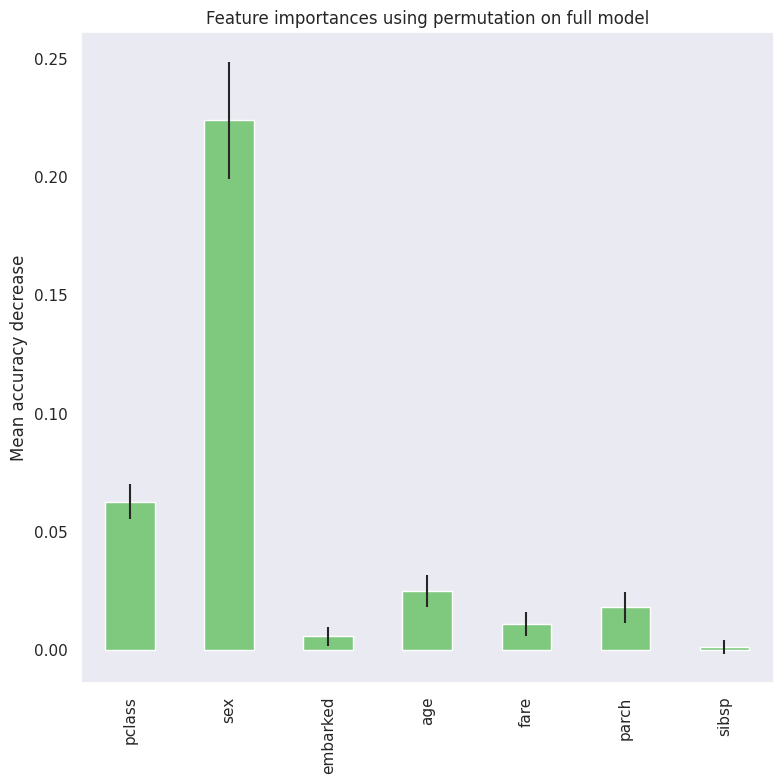

In [25]:
from sklearn.inspection import permutation_importance
result = permutation_importance(
    clf_forest, X_test[list(('pclass', 'sex', 'embarked', 'age', 'fare', 'parch', 'sibsp'))], y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()
